In [1]:
using DifferentialEquations
include("src/Utils.jl")
include("src/Models.jl")
include("src/Params.jl");
using Plots; gr();

## Add leakiness to only the kinase terms

In [294]:
"""
At low temperatures kSU can be different from kSUB. See Axmann et al. 2004 Fig. 4 and Gopal's preliminary data
"""
function kaiabc_phong_low_temp!(dX, X, p, t)

    # U: unphosphorylated. T: only T432 phosphorylated. S: only S431 phosphorylated
    # D: doubly phosphorylated. DB: D KaiC bound with KaiB. SB: S KaiC bound with KaiB
    U, T, D, S, DB, SB = X

    # k's are reaction constants (here all are 1st-order), e.g., 
    # kTU is the per reactant rate transfering from T to U
    # kCIhyd: ATP hydrolysis rate of the CI ring
    # KA: [KaiA] that activates kinase activity to half maximum
    # A0: initial [KaiA]
    # fATP = [ATP] / ([ATP] + [ADP])
    # N: # A sequestered per D. M: # A sequestered per S
    kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU, kSUA, kSUB, kUSA, kCIhyd,
    KA, A0, fATP, N, M = p

    hill(x) = x/(x + KA)

    # KaiA sequestration
    A = max(0, A0 - N*DB - M*SB)

    #           U,      T,      D,      S,      DB,     SB
    dephos_r  = [0      kTU     0       kSU     0       kSUB
                 0      0       kDT     0       kDT     0
                 0      0       0       0       0       0
                 0      0       kDS     0       0       0
                 0      0       0       0       0       0
                 0      0       0       0       kDS     0] +
                [0      kTUA    0       kSUA    0       kSUA
                 0      0       kDTA    0       kDTA    0
                 0      0       0       0       0       0
                 0      0       kDSA    0       0       0
                 0      0       0       0       0       0
                 0      0       0       0       kDSA    0]*hill(A)
    
    #         U     T       D       S       DB      SB
    phos_r = [0     0       0       0       0       0
              kUTA  0       0       0       0       0
              0     kTDA    0       kSDA    0       0
              kUSA  0       0       0       0       0
              0     0       0       0       0       kSDA
              0     0       0       0       0       0]*hill(A)*fATP

    #        U      T       D       S       DB      SB
    hyd_r = [0      0       0       0       0       0
             0      0       0       0       0       0
             0      0       0       0       0       0
             0      0       0       0       0       0
             0      0       0  0       0       0
             0      0       0       kCIhyd  0       0]

    r = dephos_r + phos_r + hyd_r

    # conservation
    r -= I(size(r)[1]) .* sum(r, dims=1)

    # (for AD) Zygote.Buffer doesn't support in-place broadcast .=
    # see https://discourse.julialang.org/t/how-to-use-initialize-zygote-buffer/87653
    dX[:] = r*X
    nothing
end

kaiabc_phong_low_temp!

Check out the trajectories

In [295]:
kCIhyd

0.15

In [348]:
A0 = 1.0
fATP = 1.0

kSU_cold = 0.38
kSUB = 0.1


p_ori = (kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU, kSUA, kUSA, kCIhyd,
KA, A0, fATP, N, M);

p = (kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU_cold, kSUA, kSUB, kUSA, kCIhyd,
KA, A0, fATP, N, 3.);

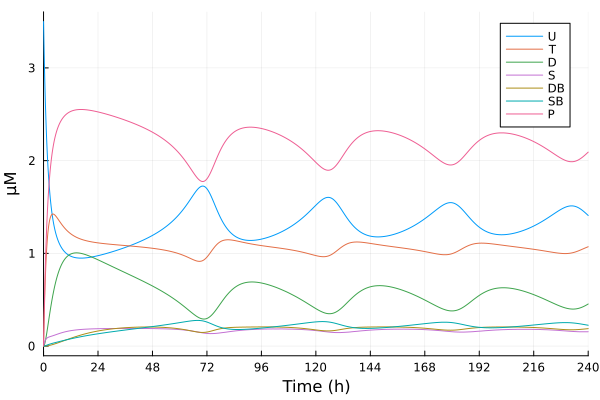

In [349]:
# U, T, D, S, DB, SB
p0 = [3.5, 0, 0, 0, 0, 0]

tmax = 240

prob = ODEProblem(kaiabc_phong_low_temp!, p0, (0.0, tmax), p)
sol = solve(prob, Tsit5(), saveat = 0.1)

plot(sol, labels=["U" "T" "D" "S" "DB" "SB"])
plot!(sol.t, 3.5*phospho_C(sol.u), label="P")
xticks!(0:24:tmax)
xlabel!("Time (h)")
ylabel!("μM")

Period and amplitude as a function of leakiness (\[KaiA\] = 1.0 uM which gives a period around 21 hours)

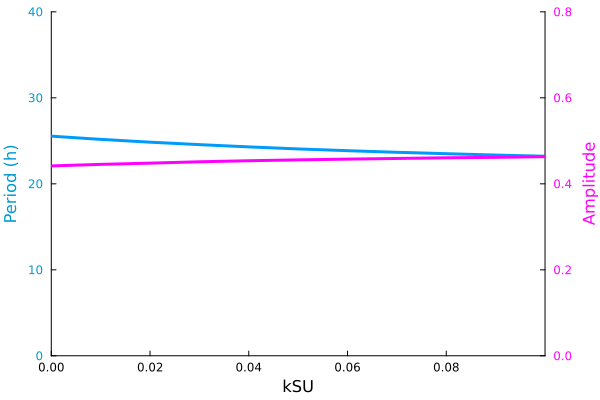

In [11]:
kSU_vec = 0.0:1e-2:kSU
kSUB = kSU

# initial conditions
u0 = [3.5, 0, 0, 0, 0, 0]

# additional params
A0 = 1.0
fATP = 1.0

p_ori = (kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU, kSUA, kUSA, kCIhyd,
KA, A0, fATP, N, M);

# find period numerically
per_mat = zeros(length(kSU_vec))
amp_mat = zeros(length(kSU_vec))
pss_vec = zeros(length(kSU_vec))
    
p0 = [1, 0, 0]

for (i, kSU) in enumerate(kSU_vec)
    
    converge, amplitude, per, phase = 
    attracted_to(kaiabc_phong_low_temp!, u0, 168, (p_ori[1:9]..., kSU, kSUA, kSUB, p_ori[12:lastindex(p_ori)]...); 
    burnin=96, conv_tol=5e-2, amp_cutoff=1e-3, tmax_stop=1e3)
    
    per_mat[i] = per == -1 ? NaN : per
    amp_mat[i] = amplitude == -1 ? NaN : amplitude

end

p = plot(kSU_vec, per_mat; legend=false, linewidth=3, framestyle=:box, grid=false,
yguidefontcolor="deepskyblue3", ytickfontcolor="deepskyblue3", ylabel="Period (h)", ylims=(0, 40))
xlabel!("kSU")
xlims!(0.0, kSU)
plot!(twinx(p), kSU_vec, amp_mat; legend=false, linewidth=3, color="magenta",
tickfontcolor="magenta", yguidefontcolor="magenta", ylabel="Amplitude", ylims=(0.0, 0.8), xlims=(0, kSU))
display(p)

Heatmap: checking out combinations of $k_{SU}$ and $k_{SUB}$

In [20]:
kSU_ori = 0.1
kSU_vec = 0.0:1e-2:(2kSU_ori)
kSUB_vec = 0.0:1e-2:(2kSU_ori)

# initial conditions
u0 = [3.5, 0, 0, 0, 0, 0]

# additional params
A0 = 1.0
fATP = 1.0

p_ori = (kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU, kSUA, kUSA, kCIhyd,
KA, A0, fATP, N, M);

# find period numerically
per_mat = zeros(length(kSU_vec), length(kSUB_vec))
amp_mat = zeros(length(kSU_vec), length(kSUB_vec))
pss_vec = zeros(length(kSU_vec), length(kSUB_vec))
    
p0 = [1, 0, 0]

for (i, kSU) in enumerate(kSU_vec)
    for (j, kSUB) in enumerate(kSUB_vec)
        converge, amplitude, per, phase = 
        attracted_to(kaiabc_phong_low_temp!, u0, 168, (p_ori[1:9]..., kSU, kSUA, kSUB, p_ori[12:lastindex(p_ori)]...); 
        burnin=96, conv_tol=5e-2, amp_cutoff=1e-3, tmax_stop=1e3)

        per_mat[i, j] = per == -1 ? NaN : per
        amp_mat[i, j] = amplitude == -1 ? NaN : amplitude
        
        print("kSU ", kSU, " kSUB ", kSUB, "\n")
    end
end

kSU 0.0 kSUB 0.0
kSU 0.0 kSUB 0.01
kSU 0.0 kSUB 0.02
kSU 0.0 kSUB 0.03
kSU 0.0 kSUB 0.04
kSU 0.0 kSUB 0.05
kSU 0.0 kSUB 0.06
kSU 0.0 kSUB 0.07
kSU 0.0 kSUB 0.08
kSU 0.0 kSUB 0.09
kSU 0.0 kSUB 0.1
kSU 0.0 kSUB 0.11
kSU 0.0 kSUB 0.12
kSU 0.0 kSUB 0.13
kSU 0.0 kSUB 0.14
kSU 0.0 kSUB 0.15
kSU 0.0 kSUB 0.16
kSU 0.0 kSUB 0.17
kSU 0.0 kSUB 0.18
kSU 0.0 kSUB 0.19
kSU 0.0 kSUB 0.2
kSU 0.01 kSUB 0.0
kSU 0.01 kSUB 0.01
kSU 0.01 kSUB 0.02
kSU 0.01 kSUB 0.03
kSU 0.01 kSUB 0.04
kSU 0.01 kSUB 0.05
kSU 0.01 kSUB 0.06
kSU 0.01 kSUB 0.07
kSU 0.01 kSUB 0.08
kSU 0.01 kSUB 0.09
kSU 0.01 kSUB 0.1
kSU 0.01 kSUB 0.11
kSU 0.01 kSUB 0.12
kSU 0.01 kSUB 0.13
kSU 0.01 kSUB 0.14
kSU 0.01 kSUB 0.15
kSU 0.01 kSUB 0.16
kSU 0.01 kSUB 0.17
kSU 0.01 kSUB 0.18
kSU 0.01 kSUB 0.19
kSU 0.01 kSUB 0.2
kSU 0.02 kSUB 0.0
kSU 0.02 kSUB 0.01
kSU 0.02 kSUB 0.02
kSU 0.02 kSUB 0.03
kSU 0.02 kSUB 0.04
kSU 0.02 kSUB 0.05
kSU 0.02 kSUB 0.06
kSU 0.02 kSUB 0.07
kSU 0.02 kSUB 0.08
kSU 0.02 kSUB 0.09
kSU 0.02 kSUB 0.1
kSU 0.02 kSUB 0.11
kSU

kSU 0.2 kSUB 0.18
kSU 0.2 kSUB 0.19
kSU 0.2 kSUB 0.2


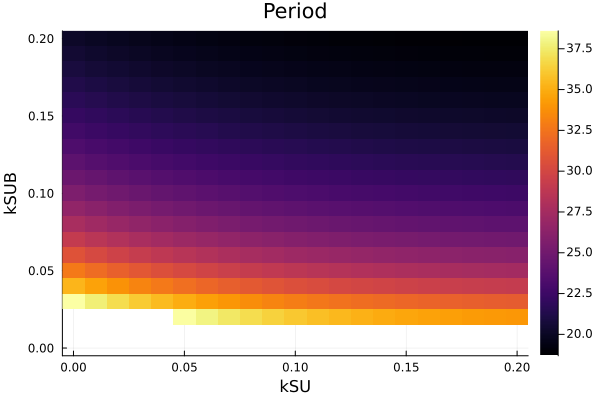

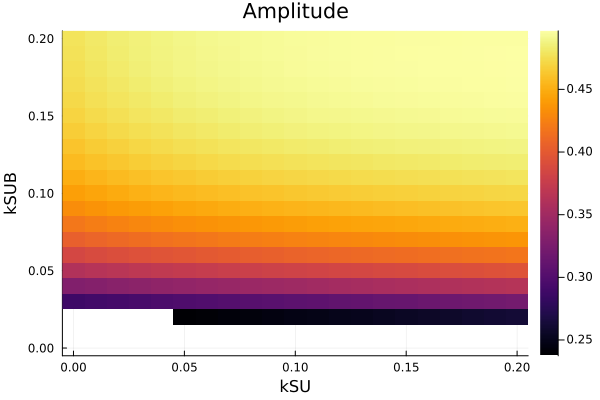

In [26]:
p1 = heatmap(kSU_vec, kSUB_vec, transpose(per_mat), xlabel="kSU", ylabel="kSUB", title = "Period")
display(p1)
heatmap(kSU_vec, kSUB_vec, transpose(amp_mat), xlabel="kSU", ylabel="kSUB", title = "Amplitude")

In [270]:
kSU_vec = 0.0:5e-3:kSU_ori
kCIhyd_vec = 0.0:0.05:1.2

# initial conditions
u0 = [3.5, 0, 0, 0, 0, 0]

# additional params
A0 = 1.0
fATP = 1.0


# find period numerically
per_mat = zeros(length(kSU_vec), length(kCIhyd_vec))
amp_mat = zeros(length(kSU_vec), length(kCIhyd_vec))
pss_vec = zeros(length(kSU_vec), length(kCIhyd_vec))


for (i, _kSU) in enumerate(kSU_vec)
    for (j, _kCIhyd) in enumerate(kCIhyd_vec)
        
        p = (kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, _kSU, kSUA, 0.1, kUSA, _kCIhyd,
        KA, A0, fATP, N, M);

        converge, amplitude, per, phase = 
        attracted_to(kaiabc_phong_low_temp!, u0, 168, p; 
        burnin=96, conv_tol=5e-2, amp_cutoff=1e-3, tmax_stop=1e3)

        per_mat[i, j] = per == -1 ? NaN : per
        amp_mat[i, j] = amplitude == -1 ? NaN : amplitude
        
        print("kSU ", _kSU, " kCIhyd ", _kCIhyd, "\n")
    end
end

kSU 0.0 kCIhyd 0.0
kSU 0.0 kCIhyd 0.05
kSU 0.0 kCIhyd 0.1
kSU 0.0 kCIhyd 0.15
kSU 0.0 kCIhyd 0.2
kSU 0.0 kCIhyd 0.25
kSU 0.0 kCIhyd 0.3
kSU 0.0 kCIhyd 0.35
kSU 0.0 kCIhyd 0.4
kSU 0.0 kCIhyd 0.45
kSU 0.0 kCIhyd 0.5
kSU 0.0 kCIhyd 0.55
kSU 0.0 kCIhyd 0.6
kSU 0.0 kCIhyd 0.65
kSU 0.0 kCIhyd 0.7
kSU 0.0 kCIhyd 0.75
kSU 0.0 kCIhyd 0.8
kSU 0.0 kCIhyd 0.85
kSU 0.0 kCIhyd 0.9
kSU 0.0 kCIhyd 0.95
kSU 0.0 kCIhyd 1.0
kSU 0.0 kCIhyd 1.05
kSU 0.0 kCIhyd 1.1
kSU 0.0 kCIhyd 1.15
kSU 0.0 kCIhyd 1.2
kSU 0.005 kCIhyd 0.0
kSU 0.005 kCIhyd 0.05
kSU 0.005 kCIhyd 0.1
kSU 0.005 kCIhyd 0.15
kSU 0.005 kCIhyd 0.2
kSU 0.005 kCIhyd 0.25
kSU 0.005 kCIhyd 0.3
kSU 0.005 kCIhyd 0.35
kSU 0.005 kCIhyd 0.4
kSU 0.005 kCIhyd 0.45
kSU 0.005 kCIhyd 0.5
kSU 0.005 kCIhyd 0.55
kSU 0.005 kCIhyd 0.6
kSU 0.005 kCIhyd 0.65
kSU 0.005 kCIhyd 0.7
kSU 0.005 kCIhyd 0.75
kSU 0.005 kCIhyd 0.8
kSU 0.005 kCIhyd 0.85
kSU 0.005 kCIhyd 0.9
kSU 0.005 kCIhyd 0.95
kSU 0.005 kCIhyd 1.0
kSU 0.005 kCIhyd 1.05
kSU 0.005 kCIhyd 1.1
kSU 0.005 kCIhyd 1.

kSU 0.075 kCIhyd 0.85
kSU 0.075 kCIhyd 0.9
kSU 0.075 kCIhyd 0.95
kSU 0.075 kCIhyd 1.0
kSU 0.075 kCIhyd 1.05
kSU 0.075 kCIhyd 1.1
kSU 0.075 kCIhyd 1.15
kSU 0.075 kCIhyd 1.2
kSU 0.08 kCIhyd 0.0
kSU 0.08 kCIhyd 0.05
kSU 0.08 kCIhyd 0.1
kSU 0.08 kCIhyd 0.15
kSU 0.08 kCIhyd 0.2
kSU 0.08 kCIhyd 0.25
kSU 0.08 kCIhyd 0.3
kSU 0.08 kCIhyd 0.35
kSU 0.08 kCIhyd 0.4
kSU 0.08 kCIhyd 0.45
kSU 0.08 kCIhyd 0.5
kSU 0.08 kCIhyd 0.55
kSU 0.08 kCIhyd 0.6
kSU 0.08 kCIhyd 0.65
kSU 0.08 kCIhyd 0.7
kSU 0.08 kCIhyd 0.75
kSU 0.08 kCIhyd 0.8
kSU 0.08 kCIhyd 0.85
kSU 0.08 kCIhyd 0.9
kSU 0.08 kCIhyd 0.95
kSU 0.08 kCIhyd 1.0
kSU 0.08 kCIhyd 1.05
kSU 0.08 kCIhyd 1.1
kSU 0.08 kCIhyd 1.15
kSU 0.08 kCIhyd 1.2
kSU 0.085 kCIhyd 0.0
kSU 0.085 kCIhyd 0.05
kSU 0.085 kCIhyd 0.1
kSU 0.085 kCIhyd 0.15
kSU 0.085 kCIhyd 0.2
kSU 0.085 kCIhyd 0.25
kSU 0.085 kCIhyd 0.3
kSU 0.085 kCIhyd 0.35
kSU 0.085 kCIhyd 0.4
kSU 0.085 kCIhyd 0.45
kSU 0.085 kCIhyd 0.5
kSU 0.085 kCIhyd 0.55
kSU 0.085 kCIhyd 0.6
kSU 0.085 kCIhyd 0.65
kSU 0.085 kCIhy

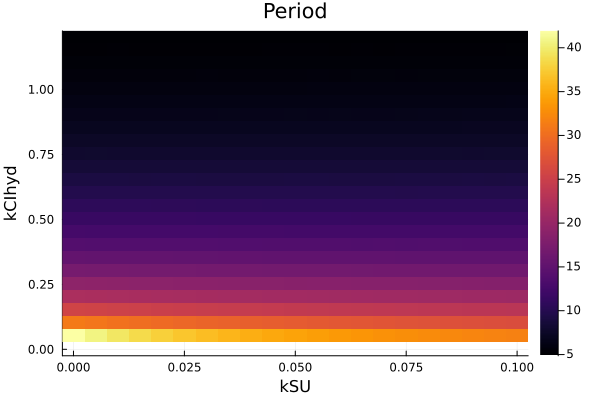

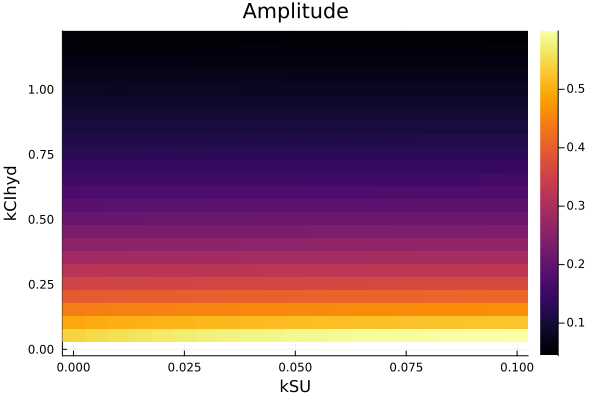

In [290]:
p1 = heatmap(kSU_vec, kCIhyd_vec, transpose(per_mat), xlabel="kSU", ylabel="kCIhyd", title = "Period")
display(p1)
heatmap(kSU_vec, kCIhyd_vec, transpose(amp_mat), xlabel="kSU", ylabel="kCIhyd", title = "Amplitude")